In [1]:
from utils import *
from preprocessing import *
from cnn_model import *
from skimage import measure
from skimage.segmentation import active_contour
from skimage.filters import gaussian
SIZE = 256

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Prepare Data

In [2]:
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)


In [3]:
print(X.shape)
print(Y.shape)

(526, 64, 64, 1)
(526, 1, 32, 32)


# First Layer: CNN

In [4]:
cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)
print(y_pred.shape)

(279, 1, 32, 32)


In [42]:
# prepare the cropped training set and test set
roi_tv_re = np.reshape(roi_tv, (roi_tv.shape[0], 1, roi_tv.shape[1], roi_tv.shape[2]))

cropped_img_train = get_cropped(img_tv, roi_tv_re)
cropped_mask_train = get_cropped(np.concatenate((mask_train, mask_val), axis = 0), roi_tv_re)

cropped_img_test = cropped
cropped_mask_test = get_cropped(mask_test, y_pred)

print(cropped_img_train.shape)
print(cropped_mask_train.shape)
print(cropped_img_test.shape)
print(cropped_mask_test.shape)


(526, 100, 100, 1)
(526, 100, 100, 1)
(279, 100, 100, 1)
(279, 100, 100, 1)


(526, 100, 100, 1)
(526, 100, 100, 1)


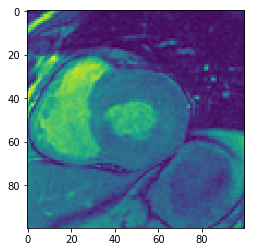

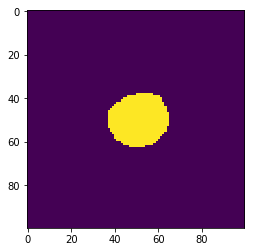

In [43]:
print(cropped_img_train.shape)
print(cropped_mask_train.shape)
plt.figure()
plt.imshow(cropped_train[10,:,:,0])
plt.figure()
plt.imshow(cropped_mask_train[10, :,:,0])

In [44]:
# down sampling the training image to (N, 64, 64) then reshape to (N, 4096)
def prepareDataSAE(X, Y, LEN = 64):
    # input should be cropped image and binary mask, shape (N, 100, 100, 1)
    # output the expected shape data for SAE model, which is (N, 4096)
    # conduct down sampling and reshaping in this method
    N = X.shape[0]
    X_re = np.zeros((N, LEN * LEN))
    Y_re = np.zeros((N, LEN * LEN))
    for i in range(N):
        img = X[i, :, :, 0]
        mask = Y[i, :, :, 0]
        img = cv2.resize(img, (LEN, LEN))
        mask = cv2.resize(mask, (LEN, LEN), interpolation = cv2.INTERSECT_NONE)
        X_re[i, :] = np.reshape(img, (-1, LEN * LEN))
        Y_re[i, :] = np.reshape(mask, (-1, LEN * LEN))
    return X_re, Y_re


In [45]:
X_train_SAE, Y_train_SAE = prepareDataSAE(cropped_img_train, cropped_mask_train)
X_test_SAE, Y_test_SAE = prepareDataSAE(cropped_img_test, cropped_mask_test)

(279, 4096)
(526, 4096)


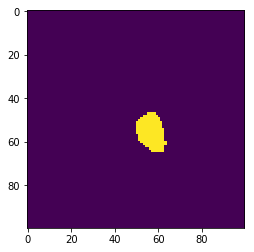

In [46]:
print(X_test_SAE.shape)
print(X_train_SAE.shape)
plt.imshow(cropped_mask_test[10,:,:,0])

# Second Layer: Stakced Autoencoder

### Load model, loss function all use MSE

In [47]:
from StackedAeModel import SAE
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train_SAE, Y_train_SAE)

### Apply result model

In [48]:
def prediction_plot(X, model, idx):
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_test_SAE,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)

### Show results from SAE

Text(0.5,1,u'Loss Curve')

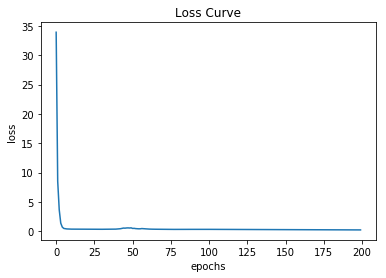

In [49]:
#plot loss curve
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Curve')

#### Dice Metrics and Conformity Coefficient

In [50]:
#Test Metrics
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_test_SAEinput[i].reshape((64,64))
    dm[i] = dice_coef(Y_true, pred_mask[i])
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
    
print ('The mean dice metric is',dm.mean())
print ('The mean conformity coefficient',cc.mean())

('The mean dice metric is', 0.516807862788614)
('The mean conformity coefficient', -4.176045942038088)


#### Demonstration

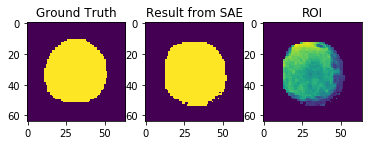

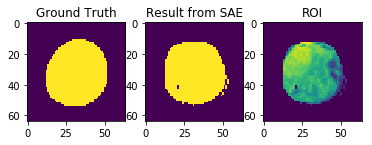

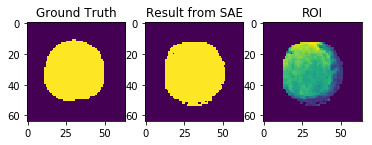

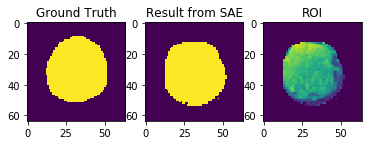

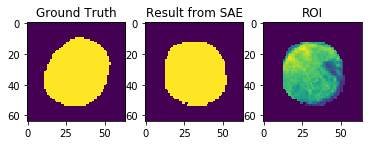

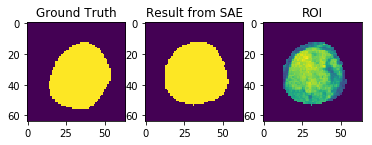

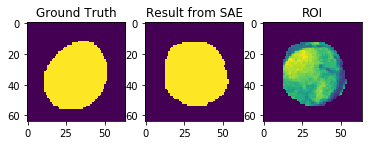

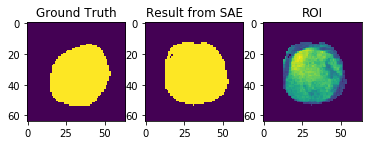

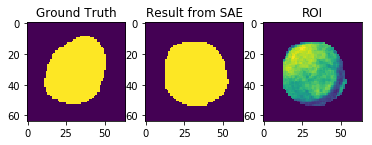

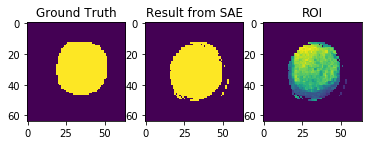

In [52]:
#find 5 highest 
demo_order = np.flip(np.argsort(dm),axis=0)
for j in range(10):
    i = demo_order[j]
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_test_SAE[i].reshape((64,64)))
    plt.title('Ground Truth')
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.title('Result from SAE')
    plt.subplot(133)
    plt.imshow(pred_img[i])
    plt.title('ROI')

# Third Layer: Active Contour

In [14]:
contour_res=[]
ac_res=[]
for i in range(n):
    X_input = img_test[i].reshape((256,256))
    X_roi = X_test_SAEinput[i].reshape((64,64))
    bin_pred = pred_mask[i]
    #Prepare Snake
    contours_pred = measure.find_contours(bin_pred, 0.5)
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
    img = X_test_SAEinput[i].reshape((64,64))
    contour_res.append(contour_pred)
    #apply active contour model
    ac_contour = active_contour(gaussian(img,3), contour_pred, alpha=0.01, beta=0.1, w_edge=0,gamma=0.01,bc='periodic',convergence=0.1)
    ac_res.append(ac_contour)

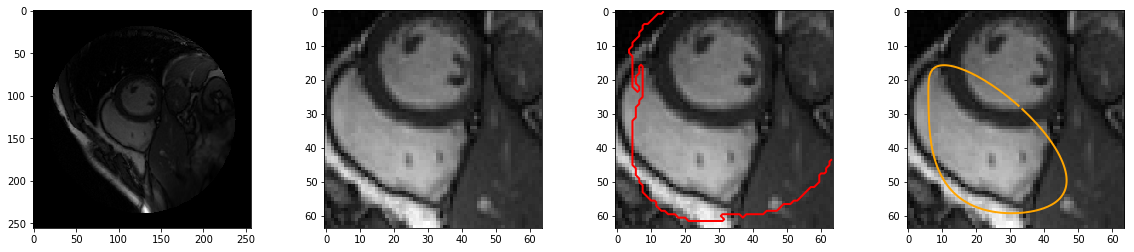

In [16]:
f, ax = plt.subplots(ncols=4, figsize=(20,4))

ax[0].imshow(img_test[266].reshape(256,256), cmap='gray')
             
ax[1].imshow(X_test_SAEinput[266].reshape(64,64), cmap='gray')
ax[2].imshow(X_test_SAEinput[266].reshape(64,64), cmap='gray')
ax[2].plot(contour_res[266][:, 1], contour_res[266][:, 0], linewidth=2, color='red',label='Prediction')
ax[3].imshow(X_test_SAEinput[266].reshape(64,64), cmap='gray')
ax[3].plot(ac_res[266][:, 1], ac_res[266][:, 0], linewidth=2, color='orange',label='Prediction')


In [18]:
#
#dm2 = np.zeros(n)
#cc2= np.zeros(n)
#for i in range(n):
#    Y_true = Y_train[i].reshape((64,64))
#    dm2[i] = dice_coef(Y_true, ac_res[i])
#    cc2[i] = conformity_coefficient(ac_res[i],Y_true)